# Solving random problem with random solutions

Today, we are going to create classification problems, and then solve them.

The first part of the Lab will be about creating a synthetic dataset using numpy, and visualizing it using matplotlib.
We will try to solve a classification problem.

In order to solve it, we will use a really simple, bruteforce approach.
As you will see, it is even, by design, stupid. But eh, if it works, it can't be that stupid!

# Exercise 1 - Data Generator.

For the first part of the tutorial, we will generate data using the numpy library, and plot it using matplotlib.


In [13]:
import numpy as np
import matplotlib.pyplot as plt


## Ex 1.a - Generating data following a gaussian distribution

I am providing you the function to generate 2-dimensional datapoints that follow a multivariate gaussian distribution centered on 0, with a covariance matrix cov.
Don't hesitate to check online wat a gaussian distribution is.

You must write a function to visualize the datapoints.

In [22]:
from numpy.random import default_rng
rng = default_rng()

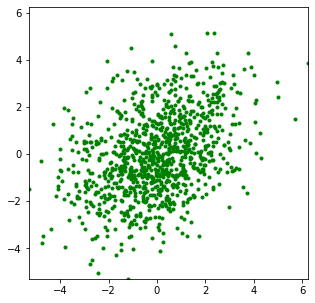

In [23]:
def generate_centered_gaussian(N, cov):
    data = rng.multivariate_normal( (0,0), cov, size = N, check_valid='ignore')
    return data

def plot_points(data_points):
    plt.figure(figsize=(5,5))
    range_point_min = np.min( data_points )
    range_point_max = np.max( data_points )
    plt.xlim(range_point_min, range_point_max)
    plt.ylim(range_point_min, range_point_max)
    plt.plot(data_points[:, 0],data_points[:, 1], 'g.' )
    
test_data = generate_centered_gaussian(1000, ((1., 3.), (3., 1.)) ) 
plot_points(test_data)

Try generating data with a covariance matrix which is 

## Ex 1.b 

Now, we will generate more complex data, that is not centered on zero.

Create a function to generate gaussians centered on center.

This function calls the function generate_centered_gaussian, and adds the offset 'center' to each point.

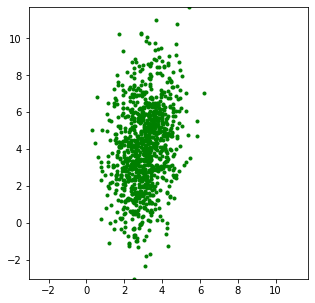

In [24]:
def generate_gaussian(N, cov, center):
    
    centered_data = generate_centered_gaussian(N, cov)
    
    data = centered_data + np.asarray(center)
    
    return data
    
test_data = generate_gaussian(1000, ((1, 0), (3, 4)), (3, 4) ) 
plot_points(test_data)

## Ex 1.c - Data Generator

I am providing a skeleton code for a class Data Generator.
DataGenerator is initialized by an argument distance.

DataGenerator will create a synthetic dataset for a binary classification problem.
Each datapoint will be of dimension 2.
It can be generated, at random, by one of two gaussian distribution:
- each gaussian has a random covariance matrix with components between -1 and 1
- one gaussian is centered on 0, the other one is centered on a random coordinate at a distance 'distance' from the origin
- if a datapoint is generated from the first gaussian, we give it a label 0
- if a datapoint is generated from the second gaussian, we give it a label 1

Your class should implement methods to:
- generate data X_0 produced by the first gaussian, and X_1 produced by the second gaussian.
- generate y_0 and y_1, the corresponding targets
- concatenate X_0 and X_1 into X, y_0 and y_1 into y
- shuffle X and y in the same way, so that the correspondence between datapoints in X and labels in y is kept.
- return the shuffled X and y

Additionally, you shoud implement a function to plot X in 2D, by assigning a different color depending on the value of y.

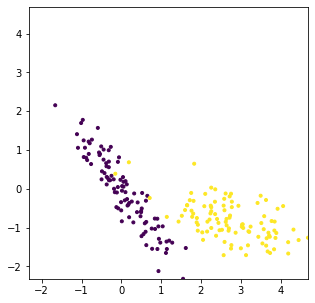

In [25]:
import random
import math

random.seed(2)

class DataGenerator:
    
    def __init__(self, distance):
        
        self.distance = distance
        
        # Center for first gaussian
        self.center_0 = (0, 0)
        
        # Center for second gaussian
        theta = random.uniform(0, 2*math.pi)
        self.center_1 = (distance*math.cos(theta), distance*math.sin(theta))
        
        # Covariance Matrices
        self.cov_0 = rng.uniform(-1, 1, (2,2))
        self.cov_1 = rng.uniform(-1, 1, (2,2))
        
    def generate_data_class(self, N, label):
        
        if label == 0:
            X = generate_gaussian(N, self.cov_0, self.center_0)
            y = np.zeros(N)
        else:
            X = generate_gaussian(N, self.cov_1, self.center_1)
            y = np.ones(N)
        
        return X, y
    
    def generate_dataset(self, N_0, N_1):
        
        X_0, y_0 = self.generate_data_class(N_0, 0)
        X_1, y_1 = self.generate_data_class(N_1, 1)
    
        X = np.concatenate([X_0, X_1])
        y = np.concatenate([y_0, y_1])
        
        random_indices = np.arange(N_0 + N_1)
        np.random.shuffle( random_indices )
        X = X[random_indices]
        y = y[random_indices]
        
        return X, y
    
def plot_points(X, y):
    
    
    plt.figure(figsize=(5,5))
    range_point_min = np.min( X )
    range_point_max = np.max( X )
    plt.xlim(range_point_min, range_point_max)
    plt.ylim(range_point_min, range_point_max)
    
    plt.scatter(X[ :, 0],X[:, 1],  marker='.',c = y)

data = DataGenerator(3)
X, y = data.generate_dataset(100,100)


plot_points(X,y)

# Exercise 3 : First Machine Learning algorithm

Let's try to tackle a classification problem.
The point of the exercise is explained in more details during the Lecture.

In essence, DataGenerator allows us to generate data from two gaussians. 
We can learn from which gaussian a datapoint might have been generated by trying to fit a line that split the space of datapoints into points generated from the first gaussian, and points generated from the second gaussian.

We will generate training and testing data first. 

In [26]:
data = DataGenerator(2)
X_train, y_train = data.generate_dataset(500,500)
X_test, y_test = data.generate_dataset(100,100)

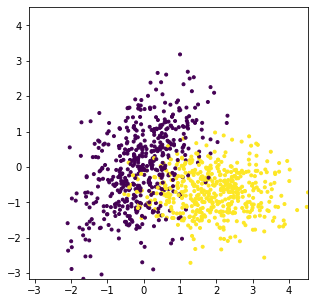

In [27]:
plot_points(X_train, y_train)

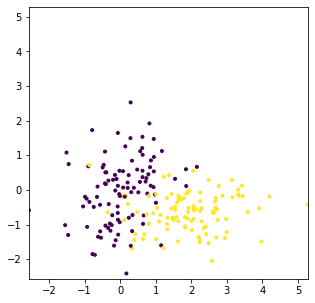

In [28]:
plot_points(X_test, y_test)

## 3.a - Projection

The main idea behind this stupid classification is to draw a line in the two-dimensional space, and check whether each point is below or above the line.

Then, we can make a decision: If the point is above the line, we say that the predicted a certain label, else we predicted the other label.
We therfore obtain a prediction y_pred, which is composed of 0s and 1s, which represent our classification results.

First, build a function classify that takes as an argument:
- X datapoints
- a the slope of a line
- b the y-axis intercept
- label_up the label assigned to points above the line.
This funtion should return a prediction of the label for each point.

Then, build a function that calculates the accuracy of your binary classifier:
Accuracy = (number of correct classifications) / (number of datapoints)

Finally, build a function to draw the datapoints, the result of their classification, and the line that led to this classification.


0.325

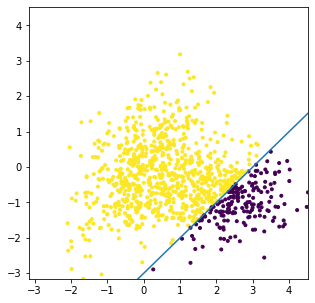

In [35]:
def classify(X, a, b, label_up):
    
    x_coordinates = X[:, 0]
    y_coordinates = X[:, 1]
   
    y_pred = (x_coordinates * a + b) > y_coordinates
    
    if label_up == 0:
        return (1 - 1.0*y_pred)
    else:
        return y_pred*1.0
    
def evaluate(y_true, y_pred):
    
    total_correct = sum( y_true == y_pred )
    
    return total_correct/len(y_true)

def plot_points_line(X, y, a, b):
    
    
    plt.figure(figsize=(5,5))
    range_point_min = np.min( X )
    range_point_max = np.max( X )
    plt.xlim(range_point_min, range_point_max)
    plt.ylim(range_point_min, range_point_max)
    
    plt.scatter(X[ :, 0],X[:, 1],  marker='.',c = y)
    
    x_line = [range_point_min, range_point_max]
    y_line = [ a * x + b for x in x_line ]
    plt.plot(x_line, y_line )
    
y_pred = classify(X_train, 1, -3, label_up = 0)
plot_points_line(X_train, y_pred, 1, -3)

evaluate(y_pred, y_train)

## 3.b - BSML Bruteforce stupid machine learning (patent pending) 

Now, we want to get the line that gives us the best split possible.
We will simply and stupidly sample random values for a, b and label_up (called model parameters).
- a and b will be picked as random float between -10 and 10.
- c will be either 0 or 1.

During training:
- we will evaluate these model parameters on the training data X_train. 
- We keep a memory of the best set of parameter, if a new set gives better results, it replaces the old parameters.
- We will also keep track of the accuracy across steps of this random search for best model parameters.

Once trained:
- we will evaluate the results on testing data

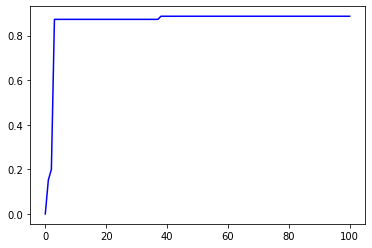

In [43]:
class BruteForceStupidML:
    
    def __init__(self, number_of_steps):
        
        self.number_of_steps = number_of_steps
        
        self.current_best_accuracy = 0
        
        self.best_params = {'a':0, 'b':0, 'label_up':0}
        
        self.results = [ (0, self.current_best_accuracy)]
        
    def train(self, X_train, y_train):
        
        for step in range(1, self.number_of_steps + 1):
            
            a_random = rng.uniform(-10, 10)
            b_random = rng.uniform(-10, 10)
            label_up_random = rng.choice([0,1])
            
            y_pred = classify(X_train, a_random, b_random, label_up_random)

            result = evaluate(y_pred, y_train)
            
            if result > self.current_best_accuracy:
                
                self.best_params['a'] = a_random
                self.best_params['b'] = b_random
                self.best_params['label_up'] = label_up_random
                
                self.current_best_accuracy = result
                
            self.results.append( (step,self.current_best_accuracy ))
                
    def plot_training_curve(self):
        
        x_results = [ r[0] for r in self.results]
        y_results = [ r[1] for r in self.results]
        
        plt.plot(x_results, y_results, '-b')
        
    def test(self, X_test, y_test):
        
        a = self.best_params['a']
        b = self.best_params['b']
        label_up = self.best_params['label_up']
        
        y_pred = classify(X_train, a ,b , label_up)
        
        return evaluate(y_pred, y_train)
    
    
bfsml = BruteForceStupidML(100)
bfsml.train(X_train, y_train)
bfsml.plot_training_curve()


            